<a href="https://colab.research.google.com/github/robert00091/Cheng-Yuan/blob/master/AI_DL_PART_2_TensorFlow_Ch04_Workshop_2_CIFAR10_with_CNNs_20190923.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 2 TensorFlow
# 4. Workshop 2 : CIFAR-10 Dataset - Classifying Images with CNNs

> **[ Reference ] :**  
  + Tom Hope, Yehezkel S. Resheff, Itay Lieder, "**Learning TensorFlow - A Guide to building Deep Learning Systems**", `Chapters 4`, O'Reilly (2017) (pdf) https://goo.gl/iEmehh
    
>    + `[ Code ]` : https://github.com/gigwegbe/Learning-TensorFlow


> + **CIFAR-10 and CIFAR-100 datasets**, 
   https://www.cs.toronto.edu/~kriz/cifar.html

- [< 1st CNN Model > : (Conv_layer + Max_pool_2x2) x 2](#CNN1)
- [< 2nd CNN Model > : (Conv_layer + Max_pool_2x2) x 3](#CNN2)
- [< 3rd CNN Model > : 3 Conv_Layers with Dropout ](#CNN3)

In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


### Download CIFAR-10 Python Version dataset from 
+ #### https://www.cs.toronto.edu/~kriz/cifar.html
+ The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

> #### [ Reference ] :  
 #### `Learning Multiple Layers of Features from Tiny Images`, Alex Krizhevsky, 2009.
https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

In [0]:
import numpy as np

class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None
    
    def load(self):
        data = [unpickle(f) for f in self._source]
        # print(data)
        images = np.vstack([d[b"data"] for d in data])
        n = len(images)  # 32 x 32 x 3 channels
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255
        self.labels = one_hot(np.hstack([d[b"labels"] for d in data]), 10)
        return self

    def next_batch(self, batch_size):
        x, y = self.images[self._i : self._i+batch_size], self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y

## Loading dataset and running this program on the Google's Colab... 

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

##  Go to this URL in a browser: https://accounts.google.com/o/oauth2/......
##  Enter your authorization code:
##   ··········
##  Mounted at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py"

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


### Loading dataset from the unzipped files...

In [0]:
import pickle
import os

##  Loading CIFAR-10 dataset from your Google Drive
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py"

##  < for CIFAR-10 dataset on local host >
##  DATA_PATH = "./cifar-10-batches-py"

def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')   ##  encoding='bytes'
    return dict

def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i)
                                   for i in range(1, 6)]).load()
        self.test = CifarLoader(["test_batch"]).load()

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test images: 10000


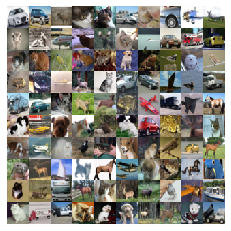

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
         for i in range(size)])
    plt.imshow(im)
    plt.show()
    
d = CifarDataManager()
print("Number of train images: {}".format(len(d.train.images)))
print("Number of train labels: {}".format(len(d.train.labels)))
print("Number of test images: {}".format(len(d.test.images)))
print("Number of test images: {}".format(len(d.test.labels)))
images = d.train.images
display_cifar(images, 10)

### Building a Computational Graph for CNN...

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

--------------------------------------
<a id='CNN1'></a>
## < 1st CNN Model > : (Conv_layer + Max_pool_2x2) x 2

--------------------------------------

+ ### Forward Propagation

In [0]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

+ ### Back-Propagation for the First Model

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv
))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Launching the First Graph...
+ **`STEPS = 10000`**
+ **`BATCH_SIZE = 100`**

In [0]:
def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
                    for i in range(10)])
    print("\n [ Accuracy ] : {:.4}%".format(acc * 100))

In [0]:
STEPS = 10000
BATCH_SIZE = 100
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                                        keep_prob: 0.5})
        if (i+1)%500 == 0:
            train_accuracy = sess.run(accuracy, 
                                      feed_dict={x: batch[0],         
                                                 y_: batch[1],
                                                 keep_prob: 1.0}) 
            print("[ STEP {} ] :\t Training Accuracy = {:.4}%".format(str(i+1).rjust(5), 
                                                               train_accuracy*100))
    
    test(sess)
    
    print(" Done !!! ")

[ STEP   500 ] :	 Training Accuracy = 62.0%
[ STEP  1000 ] :	 Training Accuracy = 68.0%
[ STEP  1500 ] :	 Training Accuracy = 75.0%
[ STEP  2000 ] :	 Training Accuracy = 80.0%
[ STEP  2500 ] :	 Training Accuracy = 80.0%
[ STEP  3000 ] :	 Training Accuracy = 80.0%
[ STEP  3500 ] :	 Training Accuracy = 85.0%
[ STEP  4000 ] :	 Training Accuracy = 91.0%
[ STEP  4500 ] :	 Training Accuracy = 92.0%
[ STEP  5000 ] :	 Training Accuracy = 95.0%
[ STEP  5500 ] :	 Training Accuracy = 95.0%
[ STEP  6000 ] :	 Training Accuracy = 97.0%
[ STEP  6500 ] :	 Training Accuracy = 99.0%
[ STEP  7000 ] :	 Training Accuracy = 98.0%
[ STEP  7500 ] :	 Training Accuracy = 100.0%
[ STEP  8000 ] :	 Training Accuracy = 100.0%
[ STEP  8500 ] :	 Training Accuracy = 99.0%
[ STEP  9000 ] :	 Training Accuracy = 99.0%
[ STEP  9500 ] :	 Training Accuracy = 99.0%
[ STEP 10000 ] :	 Training Accuracy = 100.0%

 [ Accuracy ] : 68.41%
 Done !!! 


> ### [ NOTE ] :  
 + #### The first model will achieve approximately 70% accuracy within a few minutes (using a batch size of 100, and depending naturally on hardware and configurations).
 + #### There exists `overfitting` on the first model.

-------------------------------

<a id='CNN2'></a>
## < 2nd CNN Model > : (Conv_layer + Max_pool_2x2) x 3

> + Adding a third convolution layer with 128 feature maps and dropout.
> + Reducing the number of units in the fully-connected layer from 1,024 to 512.

-------------------------------

+ ### Forward Propagation

In [0]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv3 = conv_layer(conv2_pool, shape=[5, 5, 64, 128])
conv3_pool = max_pool_2x2(conv3)

conv3_flat = tf.reshape(conv3_pool, [-1, 4 * 4 * 128])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv3_drop, 512))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

+ ### Back-Propagation for the Second Model

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv
))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Launching the Second Graph...
+ **`STEPS = 10000`**
+ **`BATCH_SIZE = 500`**

In [0]:
STEPS = 10000
BATCH_SIZE = 500
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                                        keep_prob: 0.5})
        if (i+1)%500 == 0:
            train_accuracy = sess.run(accuracy, 
                                      feed_dict={x: batch[0],         
                                                 y_: batch[1],
                                                 keep_prob: 1.0}) 
            print("[ STEP {} ] :\t Training Accuracy = {:.4}%".format(str(i+1).rjust(5), 
                                                               train_accuracy*100))
    
    test(sess)
    
    print(" Done !!! ")

[ STEP   500 ] :	 Training Accuracy = 56.8%
[ STEP  1000 ] :	 Training Accuracy = 69.0%
[ STEP  1500 ] :	 Training Accuracy = 76.2%
[ STEP  2000 ] :	 Training Accuracy = 78.6%
[ STEP  2500 ] :	 Training Accuracy = 83.4%
[ STEP  3000 ] :	 Training Accuracy = 89.6%
[ STEP  3500 ] :	 Training Accuracy = 91.4%
[ STEP  4000 ] :	 Training Accuracy = 91.6%
[ STEP  4500 ] :	 Training Accuracy = 95.4%
[ STEP  5000 ] :	 Training Accuracy = 96.8%
[ STEP  5500 ] :	 Training Accuracy = 97.0%
[ STEP  6000 ] :	 Training Accuracy = 97.0%
[ STEP  6500 ] :	 Training Accuracy = 97.8%
[ STEP  7000 ] :	 Training Accuracy = 98.2%
[ STEP  7500 ] :	 Training Accuracy = 98.8%
[ STEP  8000 ] :	 Training Accuracy = 99.6%
[ STEP  8500 ] :	 Training Accuracy = 99.6%
[ STEP  9000 ] :	 Training Accuracy = 100.0%
[ STEP  9500 ] :	 Training Accuracy = 99.8%
[ STEP 10000 ] :	 Training Accuracy = 99.8%

 [ Accuracy ] : 76.01%
 Done !!! 


> ### [ NOTE ] :  
 + #### The second model will take a bit longer to run (around 25 minutes without GPU; 10 minutes with GPU on Google's Colab) and achieve an accuracy of approximately 75%.
 + #### The *overfitting* also occurs in the second model.

-------------------------------
<a id='CNN3'></a>
## < 3rd CNN Model > : 3 Conv_Layers with Dropout

> + This model includes three blocks of convolutional layers.
> + Each block of convolutional layers contains three consecutive convolutional layers, followed by a single pooling and dropout.

-------------------------------

+ ### Forward Propagation

In [0]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

C1, C2, C3 = 30, 50, 80
F1 = 500

conv1_1 = conv_layer(x, shape=[3, 3, 3, C1])
conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
conv1_pool = max_pool_2x2(conv1_3)
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
conv2_pool = max_pool_2x2(conv2_3)
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
conv3_flat = tf.reshape(conv3_pool, [-1, C3])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full1 = tf.nn.relu(full_layer(conv3_drop, F1))  ## NOTE: One typo in Original Code here, conv3_flat
full1_drop = tf.nn.dropout(full1, keep_prob=keep_prob)
y_conv = full_layer(full1_drop, 10)

+ ### Back-Propagation for the Third Model

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv
))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Launching the Third Graph...
+ **`STEPS = 30000`**
+ **`BATCH_SIZE = 500`**

In [0]:
STEPS = 30000
BATCH_SIZE = 500
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                                        keep_prob: 0.5})
        if (i+1)%1000 == 0:
            train_accuracy = sess.run(accuracy, 
                                      feed_dict={x: batch[0],         
                                                 y_: batch[1],
                                                 keep_prob: 1.0}) 
            print("[ STEP {} ] :\t Training Accuracy = {:.4}%".format(str(i+1).rjust(5), 
                                                               train_accuracy*100))
    
    test(sess)
    
    print(" Done !!! ")

[ STEP  1000 ] :	 Training Accuracy = 43.4%
[ STEP  2000 ] :	 Training Accuracy = 53.8%
[ STEP  3000 ] :	 Training Accuracy = 61.2%
[ STEP  4000 ] :	 Training Accuracy = 65.2%
[ STEP  5000 ] :	 Training Accuracy = 73.8%
[ STEP  6000 ] :	 Training Accuracy = 77.2%
[ STEP  7000 ] :	 Training Accuracy = 80.0%
[ STEP  8000 ] :	 Training Accuracy = 80.2%
[ STEP  9000 ] :	 Training Accuracy = 83.2%
[ STEP 10000 ] :	 Training Accuracy = 84.0%
[ STEP 11000 ] :	 Training Accuracy = 83.8%
[ STEP 12000 ] :	 Training Accuracy = 84.8%
[ STEP 13000 ] :	 Training Accuracy = 85.0%
[ STEP 14000 ] :	 Training Accuracy = 87.6%
[ STEP 15000 ] :	 Training Accuracy = 88.4%
[ STEP 16000 ] :	 Training Accuracy = 88.2%
[ STEP 17000 ] :	 Training Accuracy = 88.0%
[ STEP 18000 ] :	 Training Accuracy = 89.0%
[ STEP 19000 ] :	 Training Accuracy = 89.0%
[ STEP 20000 ] :	 Training Accuracy = 89.8%
[ STEP 21000 ] :	 Training Accuracy = 91.4%
[ STEP 22000 ] :	 Training Accuracy = 89.6%
[ STEP 23000 ] :	 Training Accur

> ### [ NOTE ] :  
 + #### The third model will take about 35 minutes to run on Google's Colab with GPU setting, and achieve an accuracy of approximately 83% after 300 epochs.
 + #### The *overfitting* is improved with the third model. However, its performance is still not good enough.